In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
unemployment_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/unemployment_rate/unemployment_rate_clean.csv")
cpi_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/cpi_rate/cpi_rate_clean.csv")
income_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/income/income_clean.csv")
poverty_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/poverty/poverty_clean.csv")

In [3]:
monthly_df = pd.DataFrame({
    'Month': pd.date_range(start='2013-01-01', end='2023-12-01', freq='MS')
})
monthly_df['Year'] = monthly_df['Month'].dt.year

In [4]:
#add unemployment rate
unemployment_df['Month'] = pd.to_datetime(unemployment_df['Month'])
monthly_df = monthly_df.merge(unemployment_df, on='Month', how='left')

In [5]:
#add CPI
cpi_df['Month'] = pd.to_datetime(cpi_df['Month'])
monthly_df = monthly_df.merge(cpi_df, on='Month', how='left')
monthly_df['CPI'] = monthly_df['CPI'].interpolate(method='linear')  # linear method

In [6]:
# add income
monthly_df = monthly_df.merge(income_df, on='Year', how='left')

In [7]:
# add poverty
monthly_df = monthly_df.merge(poverty_df, on='Year', how='left')

In [8]:
# normalize all columns
scaler = MinMaxScaler()
monthly_df[['norm_unemp', 'norm_cpi', 'norm_income', 'norm_poverty']] = scaler.fit_transform(
    monthly_df[['Unemployment', 'CPI', 'Median_Household_Income', 'Poverty Rate (%)']]
)

In [9]:
monthly_df['Stress_Score'] = (
    monthly_df['norm_unemp'] +
    monthly_df['norm_poverty'] +
    monthly_df['norm_cpi'] -
    monthly_df['norm_income']
)

In [10]:
monthly_df['Stress_Score']

0           NaN
1      1.495146
2      1.476157
3      1.437751
4      1.434436
         ...   
127    0.408955
128    0.395246
129    0.410663
130    0.394337
131    0.387721
Name: Stress_Score, Length: 132, dtype: float64

In [11]:
monthly_df['Stress_Score'] = monthly_df['Stress_Score'].interpolate(method='linear') 

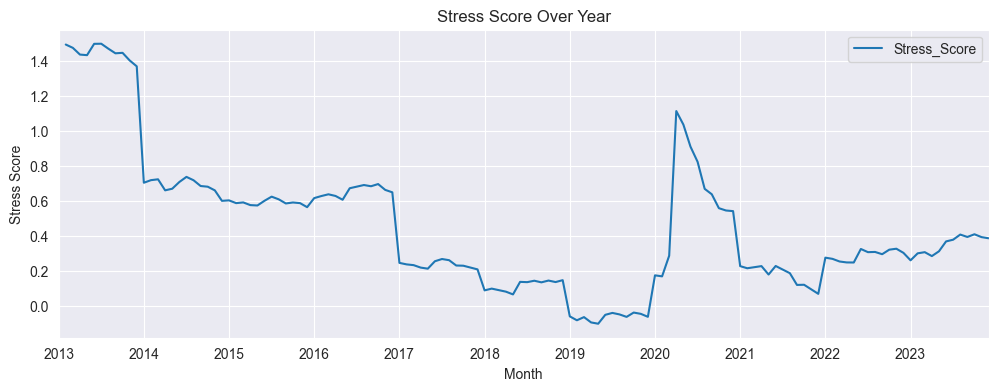

In [12]:
monthly_df.plot(x='Month', y='Stress_Score', figsize=(12, 4), title='Stress Score Over Year')
plt.ylabel('Stress Score')
plt.grid(True)
plt.show()

In [16]:
#merge 911 df
calls_df = pd.read_csv("https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/911_calls_clean.csv")
calls_df['Month'] = pd.to_datetime(calls_df['OFFENSE_DATE']).dt.to_period("M").dt.to_timestamp()
monthly_calls = calls_df.groupby("OFFENSE_DATE").size().reset_index(name="Call_Count")
monthly_calls = monthly_calls.rename(columns={'OFFENSE_DATE': 'Month'})
monthly_calls['Month'] = pd.to_datetime(monthly_calls['Month'])

In [17]:
final_df = monthly_calls.merge(monthly_df[['Month', 'Stress_Score']], on='Month', how='left')

In [18]:
final_df['Stress_Score'] = final_df['Stress_Score'].ffill()

In [19]:
final_df['Year'] = final_df['Month'].dt.year
final_df['Month_Num'] = final_df['Month'].dt.month

In [20]:
calls_df

,Unnamed: 0,PRIORITY,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO,ADDRESS,CITY,STATE,Month
0,0,4,2013-01-01,00:00:06,415FC,Public Disturbances,No Action or Unresolved,UTOPIA PL & PEAK DR,San Jose,CA,2013-01-01
1,1,4,2013-01-01,00:01:05,1062,Community Policing,No Action or Unresolved,QUIMBY RD & S WHITE RD,San Jose,CA,2013-01-01
2,2,2,2013-01-01,00:02:01,1057,Weapons Related,No Action or Unresolved,[3500]-[3600] PAYNE AV,San Jose,CA,2013-01-01
3,3,2,2013-01-01,00:02:43,1057,Weapons Related,No Action or Unresolved,[800]-[900] SAKURA DR,San Jose,CA,2013-01-01
4,4,4,2013-01-01,00:02:49,415FC,Public Disturbances,No Action or Unresolved,VINEYARD DR & SANTA TERESA BL,San Jose,CA,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...
3670173,276064,3,2024-12-31,23:48:36,1033A,Alarms and 911 Calls,No Action or Unresolved,[4100]-[4200] MONTEREY RD,San Jose,CA,2024-12-01
3670174,276065,2,2024-12-31,23:48:40,415,Public Disturbances,No Action or Unresolved,[1700]-[1800] TULLY RD,San Jose,CA,2024-12-01
3670175,276066,4,2024-12-31,23:50:27,415M,Public Disturbances,No Action or Unresolved,[1100]-[1200] ROYAL CREST DR,San Jose,CA,2024-12-01
3670176,276067,3,2024-12-31,23:57:51,415F,Public Disturbances,Report Related Outcomes,[2700]-[2800] STORY RD,San Jose,CA,2024-12-01


In [21]:
calls_df['CALL_TYPE'].unique()

array(['Public Disturbances', 'Community Policing', 'Weapons Related',
       'Substance Offenses', 'Alarms and 911 Calls', 'Public Safety',
       'Traffic and Vehicle Incidents', 'Suspicious Activity',
       'Property Crimes', 'OTHER', 'Violent Crimes',
       'Miscellaneous Crimes and Violations',
       'Juvenile and Minor Incidents'], dtype=object)

In [22]:
final_df

,Month,Call_Count,Stress_Score,Year,Month_Num
0,2013-01-01,847,NaN,2013,1
1,2013-01-02,708,NaN,2013,1
2,2013-01-03,713,NaN,2013,1
3,2013-01-04,726,NaN,2013,1
4,2013-01-05,767,NaN,2013,1
...,...,...,...,...,...
4372,2024-12-27,737,0.387721,2024,12
4373,2024-12-28,784,0.387721,2024,12
4374,2024-12-29,726,0.387721,2024,12
4375,2024-12-30,659,0.387721,2024,12


In [24]:
df_2013 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2013.csv', sep  = ',')
df_2014 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2014.csv', sep  = ',')
df_2015 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2015.csv', sep  = ',')
df_2016 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2016.csv', sep  = ',')
df_2017 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2017.csv', sep  = ',')
df_2018 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2018.csv', sep  = ',')
df_2019 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2019.csv', sep  = ',')
df_2020 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2020.csv', sep  = ',')
df_2021 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2021.csv', sep  = ',')
df_2022 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2022.csv', sep  = ',')
df_2023 = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/raw_dataset/policecalls2023.csv', sep  = ',')

frames = [df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]
all_calls = pd.concat(frames)

In [25]:
# Convert to datetime
all_calls['DATE'] = pd.to_datetime(all_calls['OFFENSE_DATE'], errors='coerce')
all_calls = all_calls.dropna(subset=['DATE'])  # Drop rows with invalid dates

# Create 'Month' column to match stress data
all_calls['Month'] = all_calls['DATE'].dt.to_period("M").dt.to_timestamp()


/var/folders/rk/pqkf6b3d2pvdw7l0_7hs338c0000gn/T/ipykernel_41032/151731961.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_calls['DATE'] = pd.to_datetime(all_calls['OFFENSE_DATE'], errors='coerce')


In [26]:
# Merge with your monthly_df or final_df that contains 'Month' and 'Stress_Score'
combined = all_calls.merge(final_df[['Month', 'Stress_Score']], on='Month', how='left')

In [27]:
# Define keywords
mental_keywords = ['MENTALLY DISTURBED', 'WELFARE CHECK', 'SUICIDE', 'DEPRESSION']

# Apply flag
combined['Mental_Health_Call'] = combined['CALL_TYPE'].str.upper().apply(
    lambda x: any(keyword in x for keyword in mental_keywords) if pd.notnull(x) else False
)


In [28]:
# Split into High vs Low stress months
stress_median = combined['Stress_Score'].median()
combined['Stress_Level'] = combined['Stress_Score'].apply(
    lambda x: 'High Stress' if x >= stress_median else 'Low Stress'
)

# Count % of mental health-related calls by stress level
mental_health_summary = combined.groupby('Stress_Level')['Mental_Health_Call'].mean().round(4) * 100
print(mental_health_summary)


Stress_Level
High Stress    8.05
Low Stress     9.07
Name: Mental_Health_Call, dtype: float64


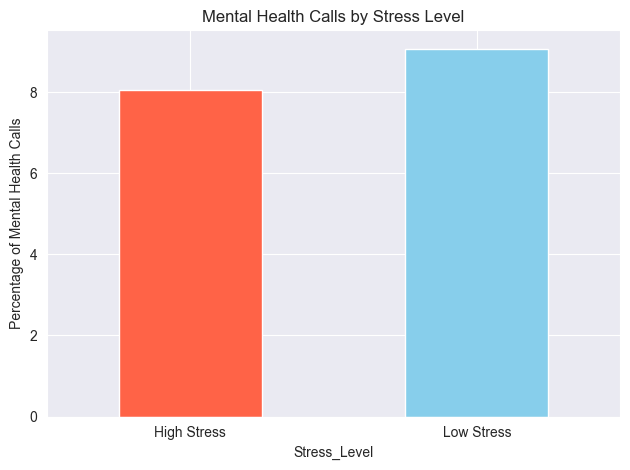

In [29]:
mental_health_summary.plot(kind='bar', color=['tomato', 'skyblue'], title='Mental Health Calls by Stress Level')
plt.ylabel("Percentage of Mental Health Calls")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


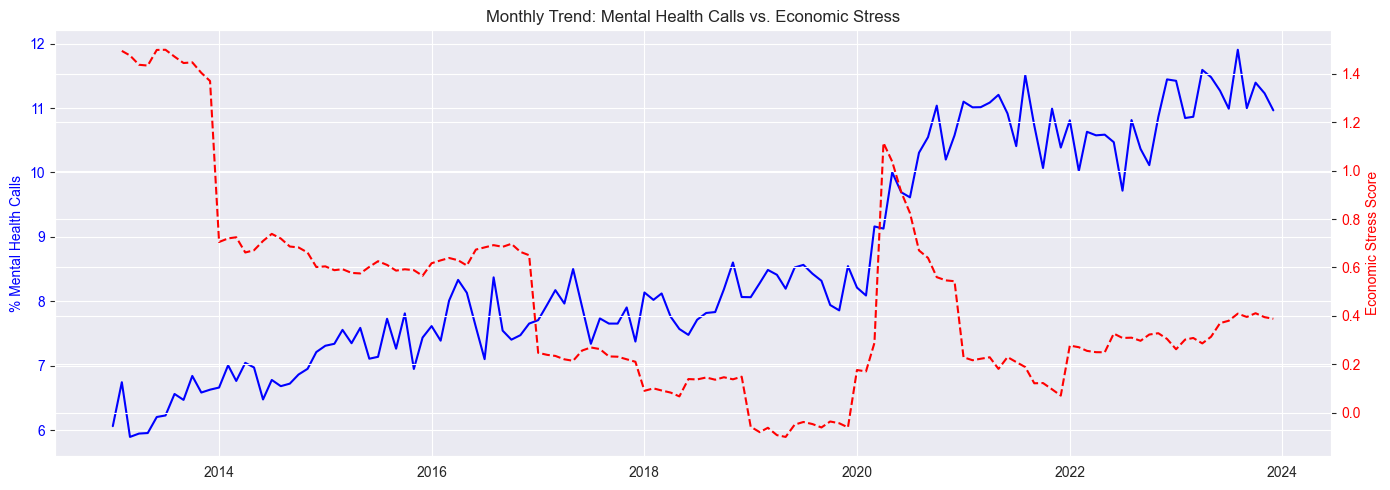

In [30]:
# Monthly mental call % over time
monthly_trend = combined.groupby('Month').agg({
    'Mental_Health_Call': 'mean',
    'Stress_Score': 'mean'
}).reset_index()
monthly_trend['Mental_Health_Call'] *= 100  # convert to %

# Plot
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(monthly_trend['Month'], monthly_trend['Mental_Health_Call'], color='blue', label='% Mental Health Calls')
ax1.set_ylabel('% Mental Health Calls', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(monthly_trend['Month'], monthly_trend['Stress_Score'], color='red', linestyle='--', label='Stress Score')
ax2.set_ylabel('Economic Stress Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Monthly Trend: Mental Health Calls vs. Economic Stress")
fig.tight_layout()
plt.grid(True)
plt.show()


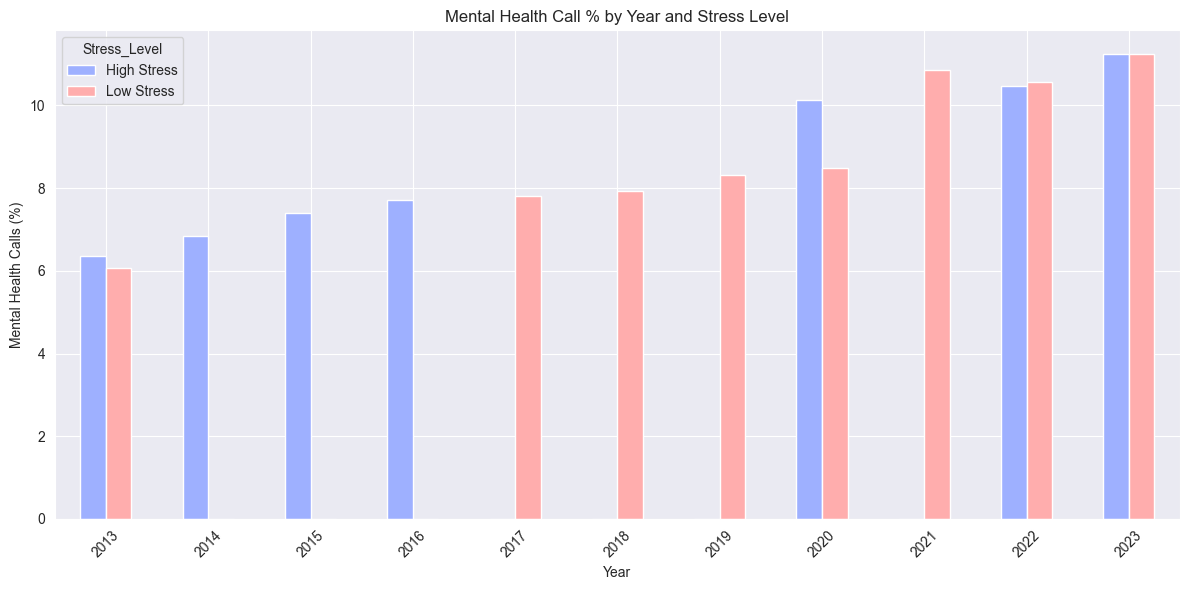

In [31]:
combined['Year'] = combined['DATE'].dt.year

# Group and calculate %
yearly = combined.groupby(['Year', 'Stress_Level'])['Mental_Health_Call'].mean().unstack() * 100

# Plot
yearly.plot(kind='bar', figsize=(12, 6), colormap='berlin')
plt.title("Mental Health Call % by Year and Stress Level")
plt.ylabel("Mental Health Calls (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
